In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
import os

def dPrime(tp_rate, fp_rate):
    # from here: https://lindeloev.net/calculating-d-in-python-and-php/
    Z = norm.ppf
    return Z(tp_rate) - Z(fp_rate)

figure_path = '/Users/lynnsorensen/surfdrive/SpatialAttention_sDCNN_2020/Figures/'
result_path = '/Users/lynnsorensen/surfdrive/SpatialAttention_sDCNN_2020/ModelEvaluation/'

save = False
colors = sns.color_palette(sns.xkcd_palette(["orange yellow", "windows blue", "greyish", "faded green", "dusty purple", "orange", "grey"]))

filename = result_path + 'Performance_150620_bootstrap.pkl'

tracker = joblib.load(result_path + 'Performance_bestModels.pkl')

# parameters for bootstrapping.
num_draws = 500
size_draws = tracker['num_samples']
np.random.seed(3)
idx = np.arange(size_draws)

if not os.path.exists(filename):
    tracker_I = joblib.load(
        '/Users/lynnsorensen/surfdrive/SpatialAttention_asn/ModelEvaluation/Performance_inputGain_100620.pkl')
    tracker_PI = joblib.load(
        '/Users/lynnsorensen/surfdrive/SpatialAttention_asn/ModelEvaluation/Performance_inputGainPrecision_150620.pkl')
    tracker_O = joblib.load(
        '/Users/lynnsorensen/surfdrive/SpatialAttention_asn/ModelEvaluation/Performance_outputGain_040620.pkl')
    tracker_PO = joblib.load(
        '/Users/lynnsorensen/surfdrive/SpatialAttention_asn/ModelEvaluation/Performance_outputGainPrecision_040620.pkl')
    tracker_x = joblib.load(
        '/Users/lynnsorensen/surfdrive/SpatialAttention_asn/ModelEvaluation/Performance_interactions_150620.pkl')
    tracker_Px = joblib.load(
        '/Users/lynnsorensen/surfdrive/SpatialAttention_asn/ModelEvaluation/Performance_interactionsPrecision_150620.pkl')

    if not os.path.exists(result_path + 'Performance_bestModels.pkl'):
        from copy import deepcopy
        tracker = deepcopy(tracker_I)
        tracker['attention_0.45'] = {}
        tracker['attention_0.45']['mode'] = tracker_I['attention_0.45']['mode']
        tracker['attention_0.45']['b_idx'] = tracker_I['attention_0.45']['b_idx']
        tracker['attention_0.45']['layers'] = tracker_I['attention_0.45']['layers']
        tracker['attention_0.45']['AxWidth'] = tracker_I['attention_0.45']['AxWidth']
        tracker['attention_0.45']['P-0_I-0.15_O-0'] = tracker_I['attention_0.45']['P-0_I-0.15_O-0']
        tracker['attention_0.45']['P-1_I-0.15_O-0'] = tracker_PI['attention_0.45']['P-1_I-0.15_O-0']
        tracker['attention_0.45']['P-1_I-0_O-0'] = tracker_PI['attention_0.45']['P-1_I-0_O-0']
        tracker['attention_0.45']['P-0_I-0_O-0.3'] = tracker_O['attention_0.45']['P-0_I-0_O-0.3']
        tracker['attention_0.45']['P-1_I-0_O-0.3'] = tracker_PO['attention_0.45']['P-1_I-0_O-0.3']
        tracker['attention_0.45']['P-0_I-0.05_O-0.2'] = tracker_x['attention_0.45']['P-0_I-0.05_O-0.2']
        tracker['attention_0.45']['P-1_I-0.05_O-0.2'] = tracker_Px['attention_0.45']['P-1_I-0.05_O-0.2']
        joblib.dump(tracker,
                    '/Users/lynnsorensen/surfdrive/SpatialAttention_asn/ModelEvaluation/Performance_bestModels.pkl',
                    compress=True)

    conds = list(tracker_I['attention_0.45'])[4:]  # get all conditions, the first 4 are defaults.
    conds.extend(list(tracker_PI['attention_0.45'])[4:])
    conds.extend(list(tracker_O['attention_0.45'])[5:])  # 5 because there are some duplicate conditions such as 'P-0_I-0_O-0'
    conds.extend(list(tracker_PO['attention_0.45'])[5:])
    conds.extend(list(tracker_x['attention_0.45']))
    conds.extend(list(tracker_Px['attention_0.45']))

    performance = pd.DataFrame(np.full((len(conds) * 2 * num_draws,7), np.nan), columns=['Model','Precision', 'Input gain','Output gain', 'Attention', 'Draw', 'AUC'])
    performance['Attention'] = np.repeat(np.arange(2)[np.newaxis,:], len(conds) * num_draws, axis=0).flatten()
    performance['Model'] = np.repeat(np.arange(len(conds))[np.newaxis,:],2 * num_draws, axis=1).flatten()
    performance['Draw'] = np.repeat(np.arange(num_draws)[np.newaxis,:],2 * len(conds), axis=0).flatten()

    replace_map = {'Attention': {0: 'valid', 1: 'invalid'}}
    performance.replace(replace_map, inplace=True)

    for c in range(len(conds)):
        cond = conds[c]
        splits = cond.split('_')

        performance.loc[performance['Model'] == c, 'Precision'] = float(splits[0].split('-')[1])
        performance.loc[performance['Model'] == c, 'Input gain'] = float(splits[1].split('-')[1])
        performance.loc[performance['Model'] == c, 'Output gain'] = float(splits[2].split('-')[1])

        performance.loc[performance['Model'] == c, 'Model'] = cond

    for tracker in [tracker_I, tracker_PI, tracker_O, tracker_PO, tracker_x, tracker_Px]:
        if 'mode' in tracker['attention_0.45']:
            conds_current = list(tracker['attention_0.45'])[4:]
        else:
            conds_current = list(tracker['attention_0.45'])
        for cond in conds_current:
            print(cond)
            for att in ['valid', 'invalid']:
                for i in range(num_draws):
                    # Resampling, with replacement, taking the class imbalance into account
                    draw = resample(idx, n_samples=size_draws, random_state=i, stratify=tracker['y_train_single'])
                    performance.loc[(performance['Model'] == cond) & (performance['Attention'] == att) & (
                            performance['Draw'] == i), 'AUC'] = roc_auc_score(tracker['y_train_single'][draw],
                                                                              np.mean(
                                                                                  tracker['attention_0.45'][cond][att][
                                                                                      'predictions'][draw,
                                                                                  tracker['start_eval']:, :], axis=1))

    performance['Difference to baseline AUC'] = performance['AUC'] - performance.loc[
        (performance['Model'] == 'P-0_I-0_O-0'), 'AUC'].mean()

    del tracker_I, tracker_PI, tracker_O, tracker_PO, tracker_x, tracker_Px

    # Save the results
    performance.to_pickle(filename)

else:
    performance = pd.read_pickle(filename)



Attention  Model           
valid      P-0_I-0.05_O-0.2    0.827572
Name: AUC, dtype: float64


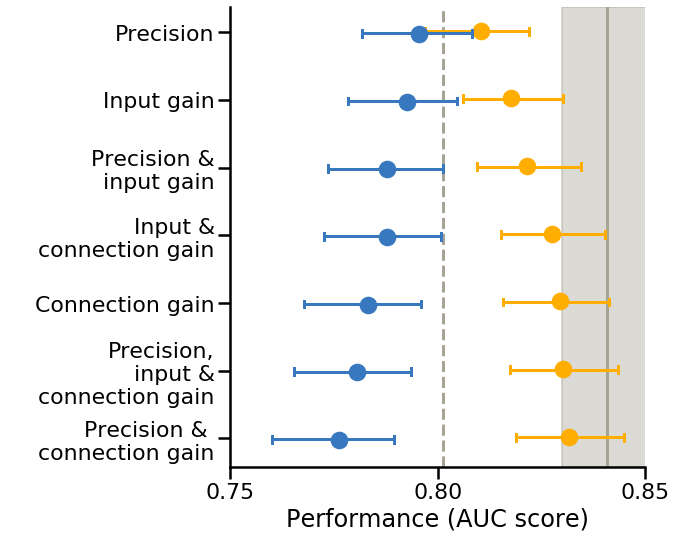

In [2]:
# Compare the different parameters
sns.set_context("poster")

best_tmp = performance.loc[(performance['Precision']==0) & (performance['Output gain']< 0.35) & (performance['Output gain']!= 0) & (performance['Input gain']!= 0)].groupby(['Attention', 'Model'])['AUC'].mean()

print(best_tmp[best_tmp == best_tmp.max()])

# Compare the winning models directly in their performance
# Obtain estimates for analog and baseline
analog_draws = list()

for i in range(num_draws):
    # Resampling, with replacement, taking the class imbalance into account
    draw = resample(idx, n_samples=size_draws, random_state=i, stratify=tracker['y_train_single'])
    #draw = idx
    analog_draws.append(roc_auc_score(tracker['y_train_single'][draw],tracker['analog']['predictions'][draw]))

performance['Analog performance range'] = (performance['AUC']-tracker['analog']['chance_AUC'])/ (tracker['analog']['AUC']- tracker['analog']['chance_AUC'])
analog_draws_range = (np.array(analog_draws)-tracker['analog']['chance_AUC'])/ (tracker['analog']['AUC']- tracker['analog']['chance_AUC'])

order = ['P-1_I-0_O-0.3', 'P-1_I-0.05_O-0.2', 'P-0_I-0_O-0.3','P-0_I-0.05_O-0.2','P-1_I-0.15_O-0', 'P-0_I-0.15_O-0', 'P-1_I-0_O-0']
mode = 'points_h'
if mode == 'bars':
    g = sns.catplot(x="Model", y='Analog performance range', hue="Attention",
                    data=performance.loc[(performance['Model'] == 'P-1_I-0_O-0') | (performance['Model'] == 'P-0_I-0.15_O-0') |
                        (performance['Model'] == 'P-1_I-0.15_O-0') | (performance['Model'] == 'P-0_I-0_O-0.3') |
                        (performance['Model'] == 'P-1_I-0_O-0.3') | (performance['Model'] == 'P-0_I-0.05_O-0.2')|
                        (performance['Model'] == 'P-1_I-0.05_O-0.2')],
                    height=8, aspect=2.2, kind="bar", palette={'valid': colors[0], 'invalid': colors[1]},
                    legend=False, zorder=3, ci=None,
                    order=order)

    i = 0
    for att in ['valid', 'invalid']:
        for cond in order:
            p = g.ax.patches[i]
            vals = performance.loc[(performance['Model'] == cond) & (performance['Attention'] == att), 'Analog performance range'].values
            x = p.get_x()+p.get_width()/2.
            g.ax.plot(np.ones(2) * x,[np.percentile(vals, 2.5), np.percentile(vals, 97.5)], color=colors[-1], zorder=4, lw=5 )
            i = i+1
elif mode == 'points':
    dodge = True
    capsize = 0.1
    aspect = 1.85
    errwidth = 3

    g = sns.catplot(y="Model", x='Analog performance range', hue="Attention",
                    data=performance.loc[(performance['Model'] == 'P-1_I-0_O-0') | (performance['Model'] == 'P-0_I-0.15_O-0') |
                        (performance['Model'] == 'P-1_I-0.15_O-0') | (performance['Model'] == 'P-0_I-0_O-0.3') |
                        (performance['Model'] == 'P-1_I-0_O-0.3') | (performance['Model'] == 'P-0_I-0.05_O-0.2')|
                        (performance['Model'] == 'P-1_I-0.05_O-0.2')],
                    height=8, aspect=aspect, kind="point", palette={'valid': colors[0], 'invalid': colors[1]},
                    legend=False, zorder=6, ci=None,
                    order=order, join=False, dodge=dodge)

    if dodge:
        offset = np.linspace(0, 0.025 * aspect, 2) # 0.025
        offset -= offset.mean()
    i = 0
    for a, att in enumerate(['valid', 'invalid']):
        for c, cond in enumerate(order):

            vals = performance.loc[
                (performance['Model'] == cond) & (performance['Attention'] == att), 'Analog performance range'].values

            ci_low = np.percentile(vals, 2.5)
            ci_high = np.percentile(vals, 97.5)
            at = np.arange(len(order))[c] + offset[a]
            g.ax.plot([at, at],[ci_low, ci_high], color=colors[a], zorder=1, lw = errwidth)
            if capsize is not None:
                g.ax.plot([at - capsize / 2, at + capsize / 2], [ci_low, ci_low], color=colors[a], zorder=1, lw = errwidth)
                g.ax.plot([at - capsize / 2, at + capsize / 2], [ci_high, ci_high], color=colors[a], zorder=1, lw = errwidth)

elif mode == 'points_h':
    dodge = True
    capsize = 0.1
    aspect = 1.2
    errwidth = 3
    order = ['P-1_I-0_O-0', 'P-0_I-0.15_O-0', 'P-1_I-0.15_O-0', 'P-0_I-0.05_O-0.2', 'P-0_I-0_O-0.3', 'P-1_I-0.05_O-0.2',
             'P-1_I-0_O-0.3']

    g = sns.catplot(y="Model", x='AUC', hue="Attention",
                    data=performance.loc[
                        (performance['Model'] == 'P-1_I-0_O-0') | (performance['Model'] == 'P-0_I-0.15_O-0') |
                        (performance['Model'] == 'P-1_I-0.15_O-0') | (performance['Model'] == 'P-0_I-0_O-0.3') |
                        (performance['Model'] == 'P-1_I-0_O-0.3') | (performance['Model'] == 'P-0_I-0.05_O-0.2') |
                        (performance['Model'] == 'P-1_I-0.05_O-0.2')],
                    height=8, aspect=aspect, kind="point", palette={'valid': colors[0], 'invalid': colors[1]},
                    legend=False, zorder=6, ci=None,
                    order=order, join=False, dodge=dodge)

    if dodge:
        offset = np.linspace(0, 0.025 * aspect, 2)  # 0.025
        offset -= offset.mean()
    i = 0
    for a, att in enumerate(['valid', 'invalid']):
        for c, cond in enumerate(order):

            vals = performance.loc[
                (performance['Model'] == cond) & (performance['Attention'] == att), 'AUC'].values

            ci_low = np.percentile(vals, 2.5)
            ci_high = np.percentile(vals, 97.5)
            at = np.arange(len(order))[c] + offset[a]
            g.ax.plot([ci_low, ci_high],[at, at],  color=colors[a], zorder=1, lw=errwidth)
            if capsize is not None:
                g.ax.plot([ci_low, ci_low],[at - capsize / 2, at + capsize / 2],  color=colors[a], zorder=1,
                          lw=errwidth)
                g.ax.plot([ci_high, ci_high],[at - capsize / 2, at + capsize / 2], color=colors[a], zorder=1,
                          lw=errwidth)
    g.set_yticklabels(['Precision', 'Input gain', 'Precision &\ninput gain','Input &\nconnection gain','Connection gain',
                       'Precision,\ninput &\nconnection gain','Precision & \nconnection gain'])
    plt.axvspan(np.percentile(np.array(analog_draws), 2.5), np.percentile(np.array(analog_draws), 97.5),
                color=colors[2], alpha=0.4, zorder=0)
    plt.axvline(np.mean(np.array(analog_draws)), color=colors[2], zorder=0)
    plt.axvline(np.mean(performance.loc[
                            (performance['Model'] == 'P-0_I-0_O-0'), 'AUC']), color=colors[2],
                ls='--', zorder=0)
    limits = np.array([0.75, 0.85])
    plt.xlim(limits)
    g.ax.set_xlabel('Performance (AUC score)')
    g.ax.set_xticks([0.75, 0.8, 0.85])
    #g.ax.set_xticks([0.5, 0.75, 1])
    g.ax.set_ylabel(' ')
    sns.despine(top=True, right=True)
    if save == True:
        g.savefig(figure_path + 'Performance_' + mode + '.pdf', dpi=300, transparent=True)
    else:
        plt.show()

else:
    raise ValueError("Not implemented.")



In [ ]:
# Statistical analysis, pairwise comparisons per condition
from sklearn.metrics import roc_auc_score
import random

comps = ['valid vs invalid', 'valid vs neutral', 'invalid vs neutral', 'valid vs analog']
results = {}
results_df = pd.DataFrame([], columns=['Mechanism', 'Comparison', 'Difference', 'p-values', 'significant'])
neutralPreds = np.mean(tracker['mf_0.45']['predictions'][:,tracker['start_eval']:, :], axis=1)
sampleYs = np.concatenate([tracker['y_train_single'], tracker['y_train_single']], axis=0)

idx = np.arange(neutralPreds.shape[0]*2)
# Define p (number of permutations):
p = 1000

results['Permutations'] = p
results['alpha-level'] = 0.05 / len(comps)
for cond in order:
    if cond not in results:
        results[cond] = {}
    print(cond)
    validPreds = np.mean(tracker['attention_0.45'][cond]['valid']['predictions'][:,tracker['start_eval']:, :], axis=1)
    invalidPreds = np.mean(tracker['attention_0.45'][cond]['invalid']['predictions'][:,tracker['start_eval']:, :], axis=1)

    for comp in comps:
        if comp not in results[cond]:
            print(comp)
            if comp == 'valid vs invalid':
                diff = np.abs(
                    tracker['attention_0.45'][cond]['valid']['AUC'] - tracker['attention_0.45'][cond]['invalid']['AUC'])
                samplePreds = np.concatenate([validPreds, invalidPreds], axis=0)
            elif comp == 'valid vs neutral':
                diff = np.abs(
                    tracker['attention_0.45'][cond]['valid']['AUC'] - tracker['mf_0.45']['AUC'])
                samplePreds = np.concatenate([validPreds, neutralPreds], axis=0)
            elif comp == 'invalid vs neutral':
                diff = np.abs(
                    tracker['attention_0.45'][cond]['invalid']['AUC'] - tracker['mf_0.45']['AUC'])
                samplePreds = np.concatenate([invalidPreds, neutralPreds], axis=0)
            elif comp == 'valid vs analog':
                diff = np.abs(
                    tracker['attention_0.45'][cond]['valid']['AUC'] - tracker['analog']['AUC'])
                samplePreds = np.concatenate([validPreds, tracker['analog']['predictions']], axis=0)
            else:
                raise ValueError('Comparison is not specified.')

            # Initialize permutation:
            pD = []

            # Permutation loop:
            for i in range(0, p):
                random.shuffle(idx)

                AUC_1st = roc_auc_score(sampleYs[idx[:int(len(idx)//2)], :], samplePreds[idx[:int(len(idx)//2)], :])

                AUC_2nd = roc_auc_score(sampleYs[idx[int(len(idx) // 2):], :], samplePreds[idx[int(len(idx) // 2):], :])

                pD.append(np.abs(AUC_1st -  AUC_2nd))


            p_val = len(np.where(pD>=diff)[0])/p
            print(cond + ': ' + str(p_val))

            results[cond][comp] = {}
            results[cond][comp]['Observed difference'] = diff
            results[cond][comp]['Difference distribution'] = pD
            results[cond][comp]['p-value']= p_val

            results_df = results_df.append({'Mechanism':cond, 'Comparison':comp, 'Difference':diff, 'p-values':p_val, 'significant':p_val<results['alpha-level']},ignore_index=True )


joblib.dump(results, result_path + 'PermutationTestsComparisons.pkl', compress=True)
results_df.to_csv(result_path + 'PermutationTestsComparisons_df.csv')

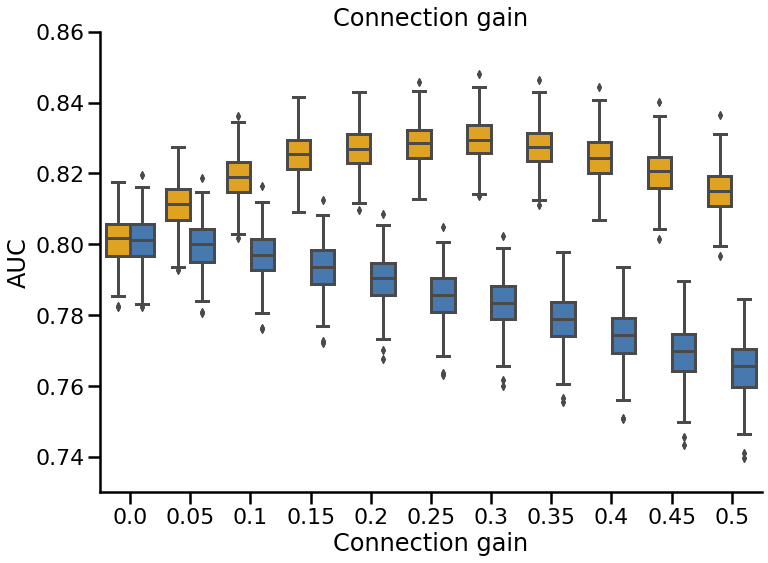

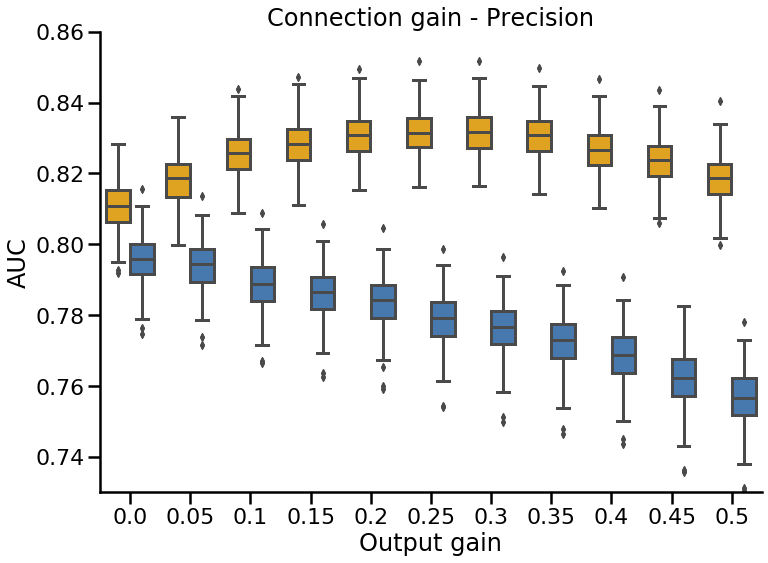

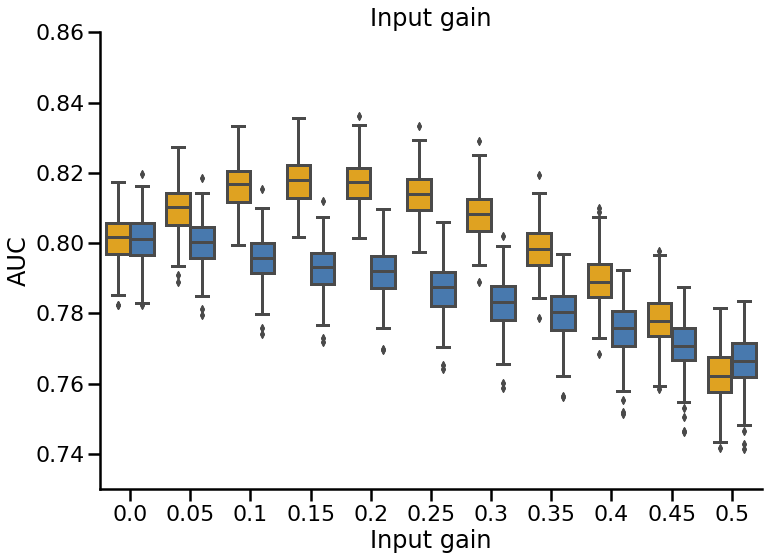

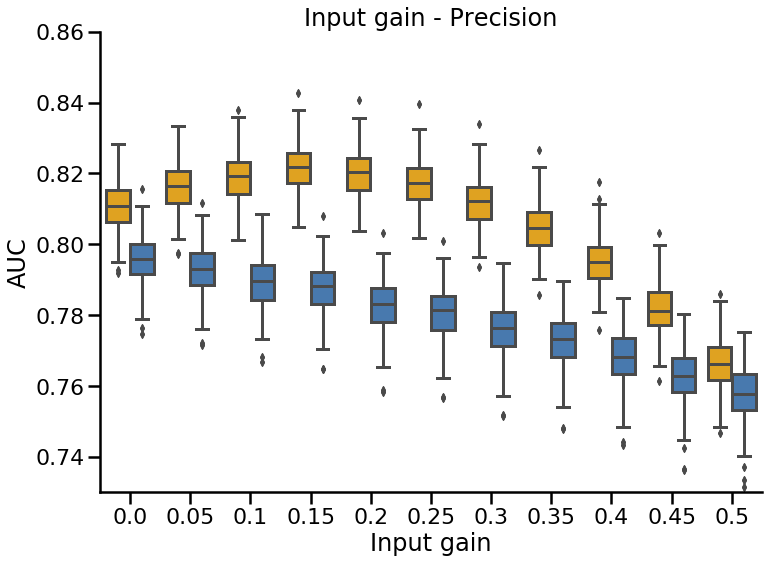

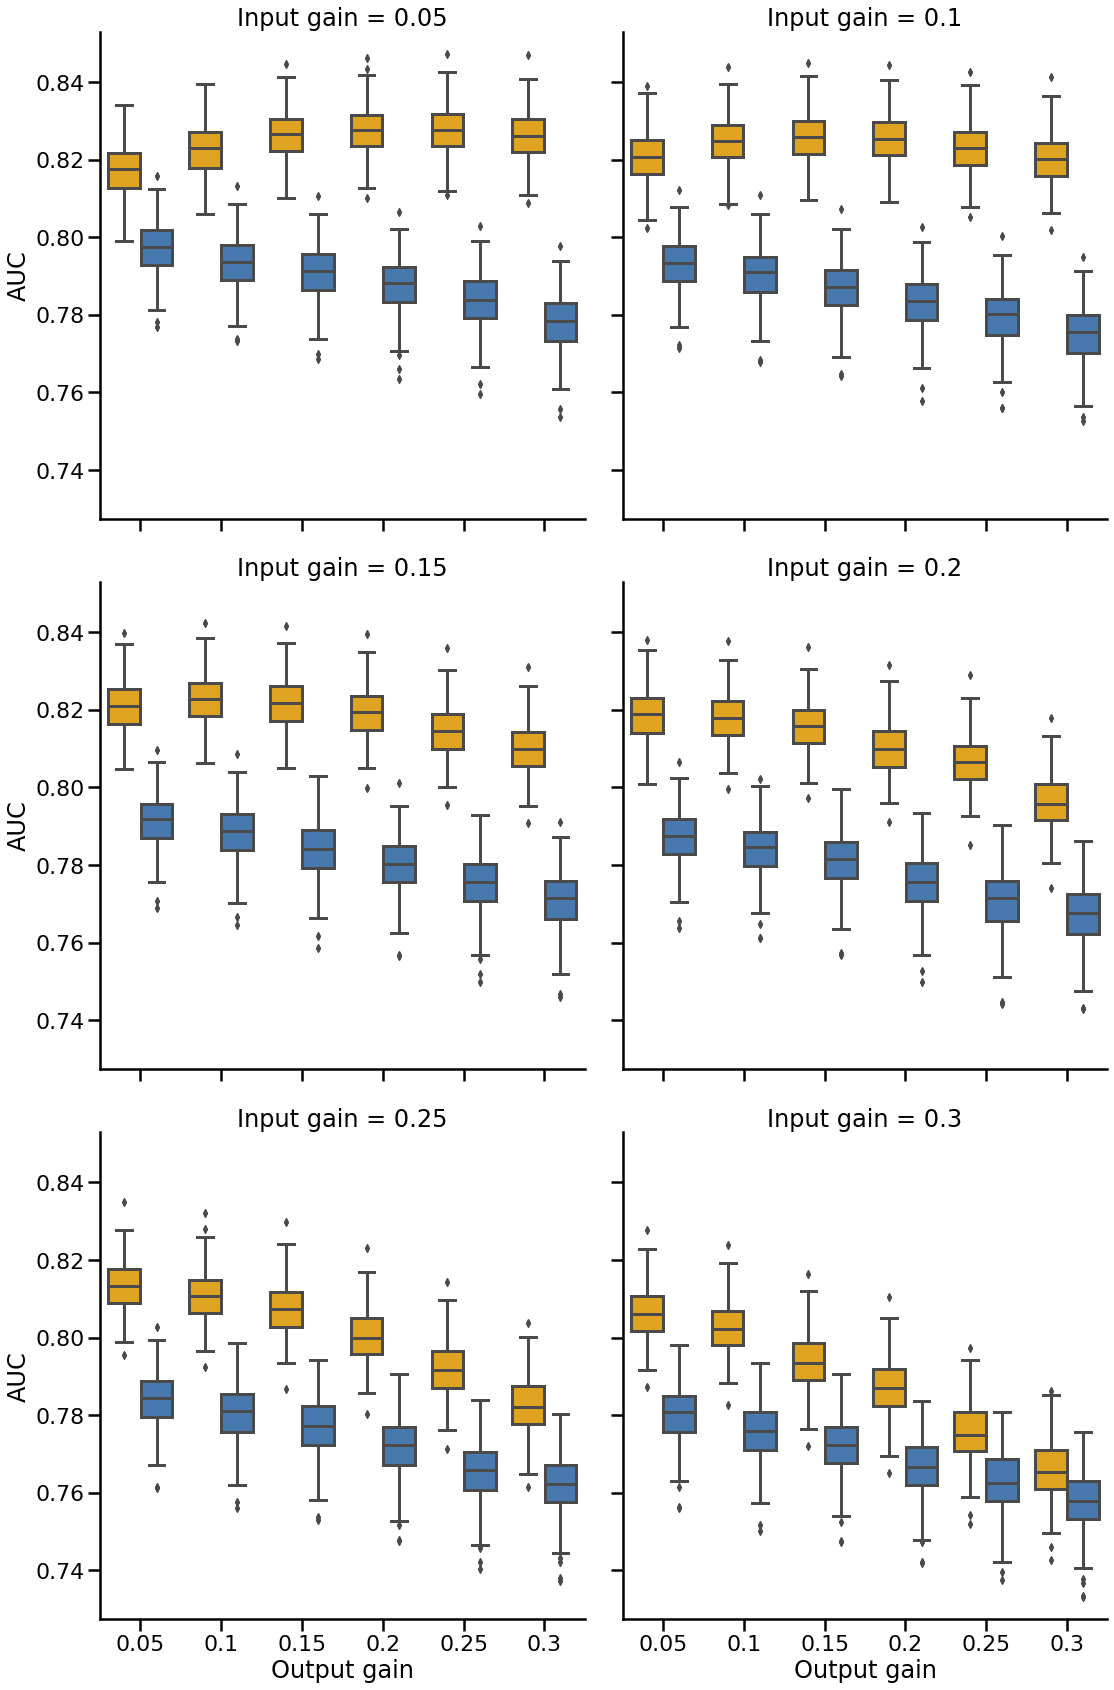

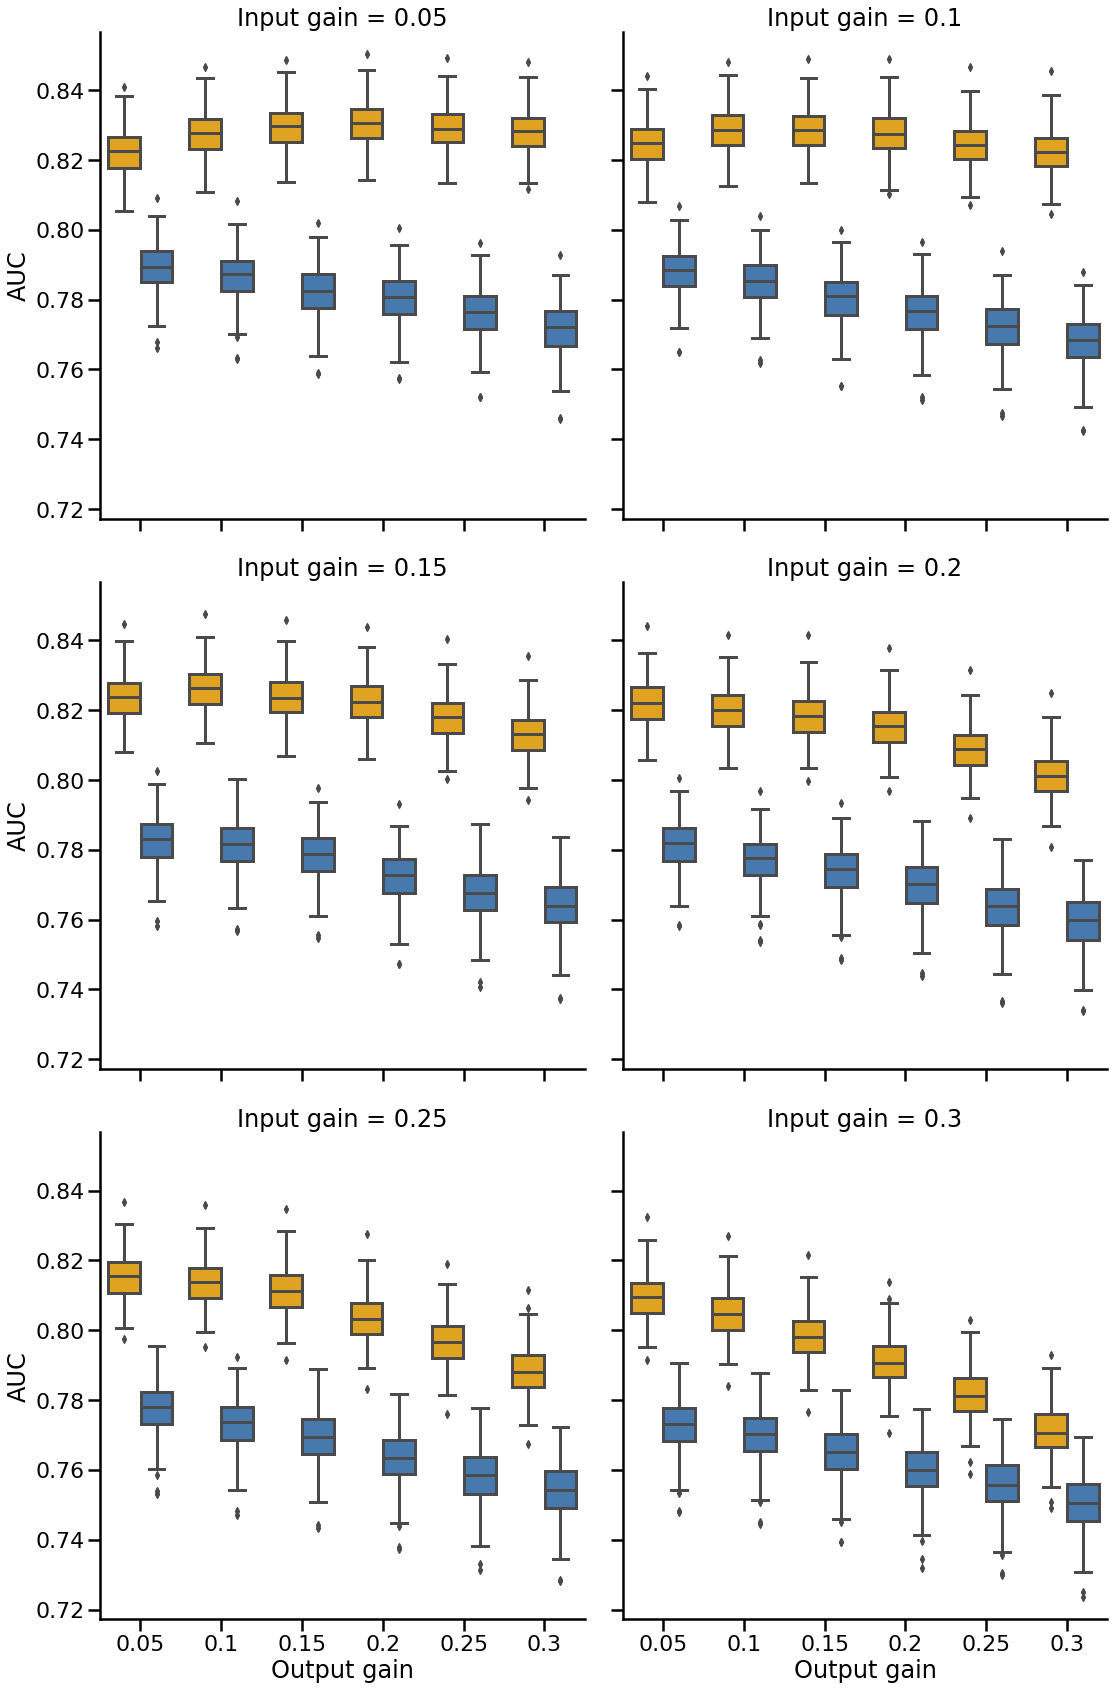

In [3]:
#  Hyper-parameters:

g = sns.catplot(x="Output gain", y='AUC', hue="Attention",
                data=performance.loc[(performance['Precision']==0) & (performance['Input gain']==0)],
                height=8, aspect=1.4, kind="box", palette={'valid': colors[0],'invalid': colors[1]},
                legend=False, zorder=2)
plt.xlabel('Connection gain')
plt.title('Connection gain')
plt.ylim([0.73, 0.86])
sns.despine()
if save == True:
    g.savefig(figure_path + 'HyperParameter_ConnectionGain.pdf', dpi=300, transparent=True)
else:
    plt.show()

g = sns.catplot(x="Output gain", y='AUC', hue="Attention",
                data=performance.loc[(performance['Precision']==1) & (performance['Input gain']==0)],
                height=8, aspect=1.4, kind="box", palette={'valid': colors[0],'invalid': colors[1]},
                legend=False)
plt.title('Connection gain - Precision')
sns.despine()
plt.ylim([0.73, 0.86])
if save == True:
    g.savefig(figure_path + 'HyperParameter_ConnectionGain-Precision.pdf', dpi=300, transparent=True)
else:
    plt.show()

g = sns.catplot(x="Input gain", y='AUC', hue="Attention",
                data=performance.loc[(performance['Precision']==0) & (performance['Output gain']==0)],
                height=8, aspect=1.4, kind="box", palette={'valid': colors[0],'invalid': colors[1]},
                legend=False)
plt.title('Input gain')
plt.ylim([0.73, 0.86])
sns.despine()
if save == True:
    g.savefig(figure_path + 'HyperParameter_InputGain.pdf', dpi=300, transparent=True)
else:
    plt.show()

g = sns.catplot(x="Input gain", y='AUC', hue="Attention",
                data=performance.loc[(performance['Precision']==1) & (performance['Output gain']==0)],
                height=8, aspect=1.4, kind="box", palette={'valid': colors[0],'invalid': colors[1]},
                legend=False)
plt.title('Input gain - Precision')

plt.ylim([0.73, 0.86])
sns.despine()
if save == True:
    g.savefig(figure_path + 'HyperParameter_InputGain-Precision.pdf', dpi=300, transparent=True)
else:
    plt.show()


g = sns.catplot(x="Output gain", y='AUC', hue="Attention", col="Input gain", col_wrap=2,
                data=performance.loc[(performance['Precision']==0) & (performance['Output gain']< 0.35) & (performance['Output gain']!= 0) & (performance['Input gain']!= 0)],
                height=8, aspect=1, kind="box", palette={'valid': colors[0],'invalid': colors[1]},
                legend=False)

sns.despine()
if save == True:
    g.savefig(figure_path + 'HyperParameter_Interactions.pdf', dpi=300, transparent=True)
else:
    plt.show()

g = sns.catplot(x="Output gain", y='AUC', hue="Attention", col="Input gain", col_wrap=2,
                data=performance.loc[(performance['Precision']==1) & (performance['Output gain']< 0.35) & (performance['Output gain']!= 0) & (performance['Input gain']!= 0)],
                height=8, aspect=1, kind="box", palette={'valid': colors[0],'invalid': colors[1]},
                legend=False)

sns.despine()
if save == True:
    g.savefig(figure_path + 'HyperParameter_Interactions-Precision.pdf', dpi=300, transparent=True)
else:
    plt.show()